<a href="https://colab.research.google.com/github/pintu1803/Fake_News_Detection_Hybrid_cnn-rnn/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection Using Hybrid CNN-RNN model.
Team project:
1. Pintu (181CO139) 
2. Akshay Dhayal (181CO105)

In the guidance of Dr. M Venkatesan (CSE Prof. @NITK)

Note: Run 1st and 2nd cell first, then comment them out and run all cells.

# Mount Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Download the GloVe: Pretrained word embedding model. It is developed by Standford NLP group. It is faster to compute than Word2Vec. Use: Dimensionality reduction

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-22 22:04:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-22 22:04:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-22 22:04:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# Load and split the data

In [ ]:
#23/03/2021
#Pintu 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd

train_raw_data=pd.read_csv('/content/drive/MyDrive/fake-news/train.csv')

#remove the missing data.
train_raw_data=train_raw_data.dropna()

x=train_raw_data['text'].values
y=train_raw_data['label'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=1000)


# Build Vocabulary 

tokenizer is the object created, of Tokenizer class. 
num_words=50000, it means we want only 1st 50k words from entire vocabulary to be used.
->> tokenizer.fit_on_texts(x_train)
action: 1) it collects all words from training data and counts the frequency of each word in that corpus.
2) All words are arranged in descending order. ie. most occured word is placed at index=1, 0 is not used as index.
3) Indexes are assigned to all unique words, but out of them only 1st 50K will be used.
4) This is stored in dictionary=word_index

->> x_train = tokenizer.texts_to_sequences(x_train)
action: All texts are converted in sequence of integers. Means that the words of text are replaced by their index in the dictionary=word_index.

->> x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
action: since all the texts are not of same length.
this will make their length equal. if text is shorter than maxlen then it will add 0's at the end (=post padding). if text size > maxlen then it will take only 1st maxlen words.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=150000)
tokenizer.fit_on_texts(x_train)

#number of unique words in dict.
print("Number of unique words in dictionary=",len(tokenizer.word_index))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  

#size of random text in training set.
print("Length of random text=",len(x_train[3]),len(x_train[13]))

maxlen = 400

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

Number of unique words in dictionary= 183144
Length of random text= 675 430


Confirm that text is converted into vector.

In [ ]:
print(type(x_train))
for row in x_train:
  print(row)
  break

<class 'numpy.ndarray'>
[    5   728  1405     6   188    87    14    12     1    93 17800   177
     1   990     6     5 98358  1653    29 11003 10872     5   174    68
     3  2095   104  1698     7    23 10003  2285  2321    16     5  1573
  2693  9587   644  2500   523     2   148    44    31   230   482  3138
    13  2706    16    68    10    23 10872    17  2500    47  4620 22098
    33   404    13    27  1293   926     1    91   739   177    68   122
     4  4542  3203     6   705  2491  5843   190  3280  6916 10556    85
    46    27    78    20   434     1  1102     2 14871    54  3173    13
  5531     7   116 11739    13   250  1453    11     1   119 42937  2454
   718     5   232     4   497   185  1553 98359  7606     9     1   168
     2  1575    30 11874 98360  4139   838     4  3009     1  6142 36869
     1   221  2492 14227    10    95  5362     4  1790 17801     3     5
 15578     4    30 12909 10004     1   762     7     1   838    16    30
 11874  1021    68     9  3

# Unzip the zip folder of GloVe

We have already downloaded and unzip the file, in previour run. 

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# Create embedding matrix using GloVe

Each word of GloVe file is searched in vocabulary=word_index.
If word is found then, its index is fetched from vocabulary. Say index = ii
The dense vector of that word from GloVe file is taken and put at same index=ii
in embedding_matrix.
SO, in total we are doing 6B * vocab_size comparasions.

embedding_dim=100, it defines the length/size of dense vector.

If we take embedding_dim=100, then model will take longer training time.

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/glove.6B.100d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

# Build Hybrid CNN-RNN model

1. The first layer of the neural network is the Keras embedding layer. This is the input layer through which the pre-trained word embeddings are utilized by providing the prepared embedding matrix and the model is trained by feeding in the training data

2. The next layer is the one-dimensional CNN layer (Conv1D) for extraction of local features by using 128 filters of size 5. The default Rectified Linear Unit (ReLU) activation function is used.

3. After that, the large feature vectors generated by CNN are pooled by feeding them in to a MaxPooling1D layer with a window size of 2, in order to down-sample the feature vectors, reduce the amount of parameters, and consequently the computations without affecting the network’s efficiency.

4. The pooled feature maps are fed into the RNN (LSTM) layer that follows. This input is used to train the LSTM, which outputs the long-term dependent features of the input feature maps, while retaining a memory. The dimension of the output is set to 32. The default linear activation function (i.e. ) of Keras is used in this layer.

5. Finally, the trained feature vectors are classified using a Dense layer that shrinks the output space dimension to 1, which corresponds to the classification label (i.e. fake or not fake). This layer applies the Sigmoid activation function.

The model is trained using the adaptive moment estimation (Adam) optimizer to define the learning rate in each iteration, the binary cross-entropy as the loss function, and the accuracy for the evaluation of results. The training is performed for 10 epochs using a batch size of 64.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 1st RUN with embedding_dim=100 & batch_size=64

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    batch_size=64)
model.summary()

Epoch 1/10
215/215 [==============================] - 122s 554ms/step - loss: 0.5496 - accuracy: 0.7023 - val_loss: 0.4011 - val_accuracy: 0.8187
Epoch 2/10
215/215 [==============================] - 121s 564ms/step - loss: 0.3412 - accuracy: 0.8458 - val_loss: 0.2972 - val_accuracy: 0.8749
Epoch 3/10
215/215 [==============================] - 119s 555ms/step - loss: 0.2375 - accuracy: 0.9205 - val_loss: 0.1936 - val_accuracy: 0.9370
Epoch 4/10
215/215 [==============================] - 119s 552ms/step - loss: 0.1396 - accuracy: 0.9553 - val_loss: 0.2073 - val_accuracy: 0.9180
Epoch 5/10
215/215 [==============================] - 118s 550ms/step - loss: 0.1313 - accuracy: 0.9508 - val_loss: 0.2228 - val_accuracy: 0.9160
Epoch 6/10
215/215 [==============================] - 118s 549ms/step - loss: 0.1141 - accuracy: 0.9667 - val_loss: 0.1780 - val_accuracy: 0.9490
Epoch 7/10
215/215 [==============================] - 120s 560ms/step - loss: 0.0704 - accuracy: 0.9795 - val_loss: 0.1694 -

# Evaluate the model

acc=training accuracy and val_acc=validation accuracy
similarly for loss.

In [ ]:
val_loss, val_acc=model.evaluate(x_test, y_test)

143/143 [==============================] - 8s 53ms/step - loss: 0.1636 - accuracy: 0.9549


# Prediction and performance measure of model

In [ ]:
from math import floor
from sklearn.metrics import classification_report, confusion_matrix
def performance(x_test, y_test):
  y_pred=model.predict(x_test)
  # print(y_pred[0])
  y_pred=[1 if x>=0.5 else 0 for x in y_pred]
  # print(y_pred[0])
  cm=confusion_matrix(y_test, y_pred)
  cr=classification_report(y_test, y_pred)

  print("Confusion matrix=\n",cm)
  print("Classification report=\n",cr)

#call the performance measure function
performance(x_test, y_test)

Confusion matrix=
 [[2509   56]
 [ 150 1857]]
Classification report=
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2565
           1       0.97      0.93      0.95      2007

    accuracy                           0.95      4572
   macro avg       0.96      0.95      0.95      4572
weighted avg       0.96      0.95      0.95      4572



It took approx. 1200 seconds or 20 minutes to run the 10 epochs.

Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training. Make sure to call clear_session() before you start training the model again:

In [ ]:
# from keras.backend import clear_session
# clear_session()

Visualize the loss and accuracy for the training and testing data based on the History callback.

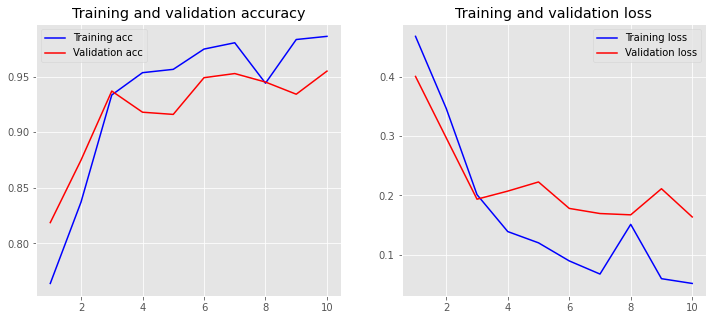

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


#call the function using history
plot_history(history)

WE can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

Note: When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

# 2nd RUN with embedding_dim=100 & batch_size=128

Epoch 1/10
108/108 [==============================] - 92s 856ms/step - loss: 0.0293 - accuracy: 0.9930 - val_loss: 0.1532 - val_accuracy: 0.9573
Epoch 2/10
108/108 [==============================] - 94s 871ms/step - loss: 0.0228 - accuracy: 0.9954 - val_loss: 0.1791 - val_accuracy: 0.9532
Epoch 3/10
108/108 [==============================] - 93s 859ms/step - loss: 0.0254 - accuracy: 0.9942 - val_loss: 0.1694 - val_accuracy: 0.9571
Epoch 4/10
108/108 [==============================] - 92s 857ms/step - loss: 0.0287 - accuracy: 0.9926 - val_loss: 0.1499 - val_accuracy: 0.9576
Epoch 5/10
108/108 [==============================] - 92s 857ms/step - loss: 0.0153 - accuracy: 0.9972 - val_loss: 0.1631 - val_accuracy: 0.9576
Epoch 6/10
108/108 [==============================] - 92s 857ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.1699 - val_accuracy: 0.9600
Epoch 7/10
108/108 [==============================] - 93s 857ms/step - loss: 0.0100 - accuracy: 0.9985 - val_loss: 0.1765 - val_ac

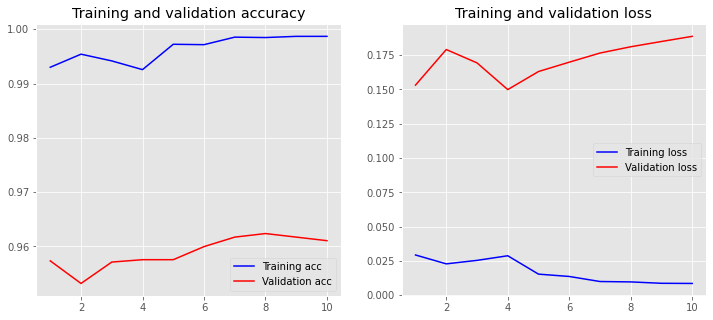

In [ ]:
from keras.backend import clear_session
clear_session()

history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    batch_size=128)

val_loss, val_acc=model.evaluate(x_test, y_test)

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))#overfitting.
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))#actual accuracy

performance(x_test, y_test)

#call the function using history
plot_history(history)

# 3rd RUN & new model with embedding_dim=50, batch_size=64

Epoch 1/10
215/215 [==============================] - 79s 359ms/step - loss: 0.5497 - accuracy: 0.7057 - val_loss: 0.3258 - val_accuracy: 0.8685
Epoch 2/10
215/215 [==============================] - 77s 359ms/step - loss: 0.3072 - accuracy: 0.8617 - val_loss: 0.2645 - val_accuracy: 0.8957
Epoch 3/10
215/215 [==============================] - 77s 358ms/step - loss: 0.2116 - accuracy: 0.9198 - val_loss: 0.2048 - val_accuracy: 0.9254
Epoch 4/10
215/215 [==============================] - 77s 359ms/step - loss: 0.1284 - accuracy: 0.9571 - val_loss: 0.2267 - val_accuracy: 0.9101
Epoch 5/10
215/215 [==============================] - 79s 369ms/step - loss: 0.2458 - accuracy: 0.9034 - val_loss: 0.1894 - val_accuracy: 0.9342
Epoch 6/10
215/215 [==============================] - 78s 361ms/step - loss: 0.1078 - accuracy: 0.9715 - val_loss: 0.1818 - val_accuracy: 0.9407
Epoch 7/10
215/215 [==============================] - 77s 359ms/step - loss: 0.0646 - accuracy: 0.9835 - val_loss: 0.1473 - val_ac

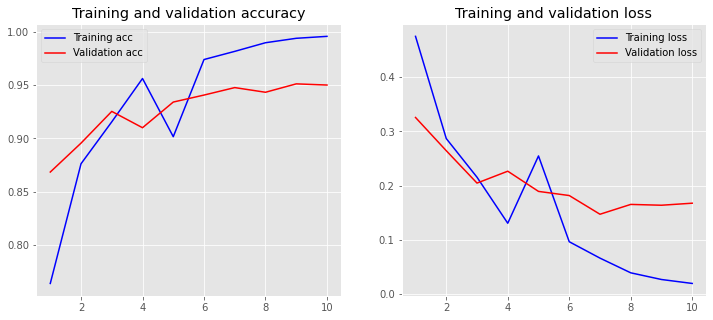

In [ ]:
clear_session()

embedding_dim = 50
#build embedding matrix.
embedding_matrix = create_embedding_matrix('/content/glove.6B.50d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

#buidl the hybrid cnn-rnn model.
model_1 = Sequential()
model_1.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model_1.add(layers.Conv1D(128, 5, activation='relu'))
model_1.add(layers.MaxPooling1D(2))
model_1.add(layers.LSTM(32))
model_1.add(layers.Dense(1, activation='sigmoid'))
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#train the model.
history_1 = model_1.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    batch_size=64)

#test the model.
val_loss, val_acc=model_1.evaluate(x_test, y_test)

loss, accuracy = model_1.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))#overfitting.
loss, accuracy = model_1.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))#actual accuracy

#confusion matrix and classification report.
performance(x_test, y_test)

#call the function using history
plot_history(history_1)

######################__A MODEL CREATED BY PINTU (181CO139) AND AKSHAY DHAYAL (181CO105) __####################